
# Interpolacja klatek pośrednich - LIFT

Projekt zakłada realizację interpolacji klatek pośrednich w materiale wideo z wykorzystaniem szerokiego kontekstu temporalnego. Model opiera się na ekstrakcji cech inspirowanej architekturą RIFE, jednak został znacząco rozszerzony o dodatkowe komponenty - w szczególności o nowe dataloadery oraz moduł transformera, który stanowi kluczowy element architektury.

Model przyjmuje na wejściu sekwencję 15 klatek, a następnie generuje klatkę pośrednią na podstawie informacji pozyskanych zarówno z klatek poprzedzających i następujących (14 klatek). Metryki jakości obliczane są w odniesieniu do klatki ground truth (ósma ramka w sekwencji) i porównywane z klatką wygenerowaną przez model.

Autorzy:

- Jakub Kubiński 318793
- Anna Celińska 318756
- Piotr Niewiński 318811

## Pytanie badawcze

Czy zastosowanie przesunięcia czasowego jako zwiększenia kontekstu temporalnego podczas interpolacji klatek pośrednich poprawia subiektywną jakość obrazu na konsumenckim układzie graficznym w porównaniu do innych modeli dwuklatkowch, ocenianą przy użyciu metryk PSNR, SSIM, LPIPS.  

## Wizualizacja metryk

Poniżej znajduje się kod realizujący generowanie interaktywnego dashboardu ewaluacyjnego dla modelu LIFT na podstawie zapisanych wyników testowych w formacie results.json.

Skrypt wczytuje metryki PSNR, SSIM i LPIPS dla wszystkich próbek, a następnie tworzy zestaw wizualizacji ilustrujących rozkłady błędów oraz zależności między poszczególnymi metrykami.

Dashboard obejmuje:

- histogramy wartości metryk,

- wykresy pudełkowe (boxploty),

- wykresy rozrzutu przedstawiające zależności pomiędzy metrykami,

- tabelę zbiorczych statystyk (średnia, odchylenie standardowe, min, max, mediana).


Opis metryk:

- **PSNR** (Peak Signal-to-Noise Ratio) - metryka określająca poziom zniekształcenia sygnału między obrazem wygenerowanym a referencyjnym, opierająca się na błędzie MSE.

- **SSIM** (Structural Similarity Index Measure) - miara oceniająca podobieństwo struktur obrazu, uwzględniająca luminancję, kontrast i teksturę.

- **LPIPS** (Learned Perceptual Image Patch Similarity) - metryka percepcyjna oparta na sieciach neuronowych. Porównuje obrazy na poziomie reprezentacji cech, odzwierciedlając postrzeganą przez człowieka różnicę wizualną.

Wizualizacja wyników została policzona podczas testu obejmującego 1000 losowych próbek z datasetu.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Wczytywanie danych z: /content/results.json...

Dashboard zapisany: metrics_dashboard.png


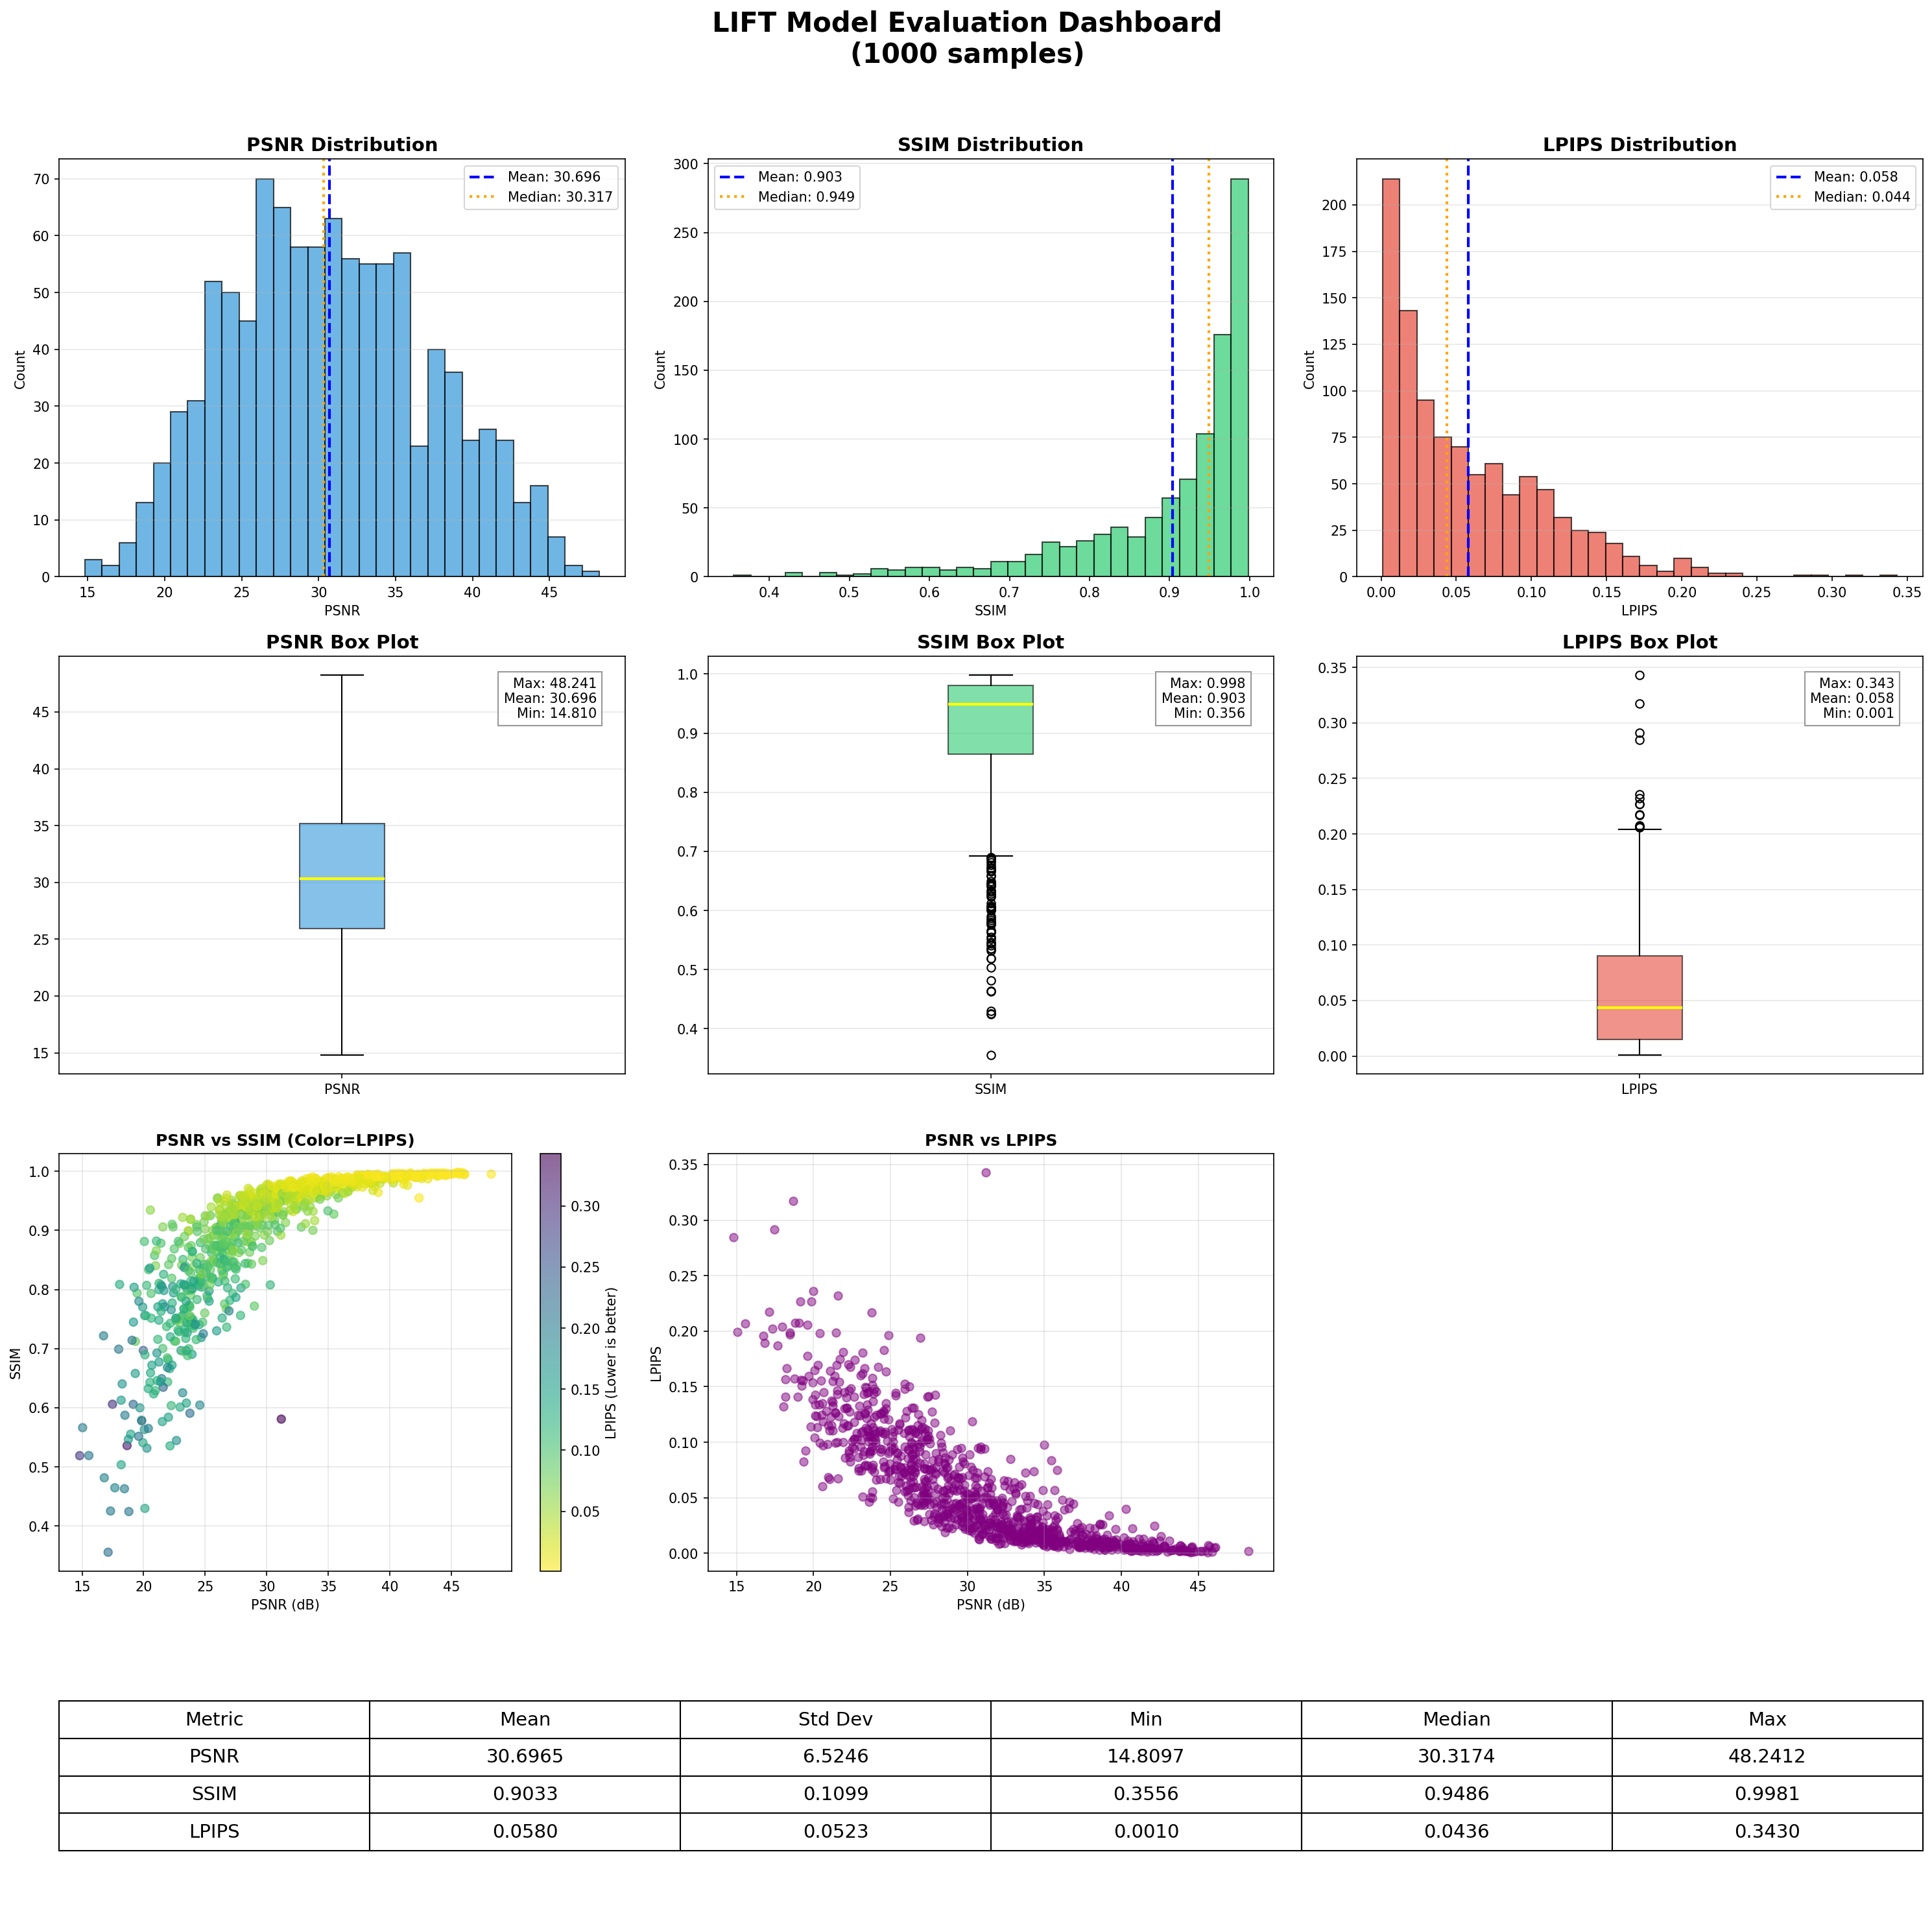

In [ ]:
import json
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from pathlib import Path
import traceback

RESULTS_DIR = '/content'
REPORT_FILENAME = 'results.json'

def create_metrics_dashboard_from_json(results_dir: str, filename: str, output_path: str):
    results_path = Path(results_dir)
    report_file = results_path / filename

    if not report_file.exists():
        raise FileNotFoundError(f"Nie znaleziono pliku raportu: {report_file}")

    print(f"Wczytywanie danych z: {report_file}...")
    with open(report_file, 'r') as f:
        report = json.load(f)

    if 'results' in report:
        results = report['results']
        if 'summary' in report:
            summary = report['summary']
        else:
            summary = {}
    else:
        results = report
        summary = {}

    # Ekstrakcja metryk
    try:
        psnr_vals = [r['metrics']['PSNR'] for r in results]
        ssim_vals = [r['metrics']['SSIM'] for r in results]
        lpips_vals = [r['metrics']['LPIPS'] for r in results]
    except KeyError:
        print("Błąd struktury JSON. Oczekiwano formatu: [{'metrics': {'PSNR': ...}}, ...]")
        return

    metrics_data = {'PSNR': psnr_vals, 'SSIM': ssim_vals, 'LPIPS': lpips_vals}

    for name, data in metrics_data.items():
        if name not in summary:
            arr = np.array(data)
            summary[name] = {
                'mean': float(np.mean(arr)),
                'std': float(np.std(arr)),
                'min': float(np.min(arr)),
                'max': float(np.max(arr)),
                'median': float(np.median(arr))
            }

    fig = plt.figure(figsize=(20, 20))
    gs = GridSpec(4, 3, figure=fig, height_ratios=[1, 1, 1, 0.6])

    fig.suptitle(f'LIFT Model Evaluation Dashboard\n({len(results)} samples)', fontsize=20, fontweight='bold', y=0.98)

    colors = {'PSNR': '#3498db', 'SSIM': '#2ecc71', 'LPIPS': '#e74c3c'}

    for i, metric in enumerate(['PSNR', 'SSIM', 'LPIPS']):
        ax = fig.add_subplot(gs[0, i])
        vals = metrics_data[metric]
        stats = summary[metric]

        ax.hist(vals, bins=30, color=colors[metric], edgecolor='black', alpha=0.7)
        ax.axvline(stats['mean'], color='blue', linestyle='--', linewidth=2, label=f"Mean: {stats['mean']:.3f}")
        ax.axvline(stats['median'], color='orange', linestyle=':', linewidth=2, label=f"Median: {stats['median']:.3f}")

        ax.set_title(f'{metric} Distribution', fontsize=14, fontweight='bold')
        ax.set_xlabel(metric)
        ax.set_ylabel('Count')
        ax.legend()
        ax.grid(axis='y', alpha=0.3)

    for i, metric in enumerate(['PSNR', 'SSIM', 'LPIPS']):
        ax = fig.add_subplot(gs[1, i])
        vals = metrics_data[metric]

        box = ax.boxplot([vals], tick_labels=[metric], patch_artist=True,
                         medianprops=dict(color='yellow', linewidth=2))

        for patch in box['boxes']:
            patch.set_facecolor(colors[metric])
            patch.set_alpha(0.6)

        ax.set_title(f'{metric} Box Plot', fontsize=14, fontweight='bold')
        ax.grid(axis='y', alpha=0.3)

        stats = summary[metric]
        text_str = (f"Max: {stats['max']:.3f}\n"
                    f"Mean: {stats['mean']:.3f}\n"
                    f"Min: {stats['min']:.3f}")

        ax.text(0.95, 0.95, text_str, transform=ax.transAxes,
                va='top', ha='right', fontsize=10,
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))

    # PSNR vs SSIM
    ax4 = fig.add_subplot(gs[2, 0])
    sc = ax4.scatter(psnr_vals, ssim_vals, c=lpips_vals, cmap='viridis_r', alpha=0.6)
    plt.colorbar(sc, ax=ax4, label='LPIPS (Lower is better)')
    ax4.set_xlabel('PSNR (dB)')
    ax4.set_ylabel('SSIM')
    ax4.set_title('PSNR vs SSIM (Color=LPIPS)', fontsize=12, fontweight='bold')
    ax4.grid(True, alpha=0.3)

    # PSNR vs LPIPS
    ax5 = fig.add_subplot(gs[2, 1])
    ax5.scatter(psnr_vals, lpips_vals, color='purple', alpha=0.5)
    ax5.set_xlabel('PSNR (dB)')
    ax5.set_ylabel('LPIPS')
    ax5.set_title('PSNR vs LPIPS', fontsize=12, fontweight='bold')
    ax5.grid(True, alpha=0.3)

    ax_stats = fig.add_subplot(gs[3, :])
    ax_stats.axis('off')

    cols = ["Metric", "Mean", "Std Dev", "Min", "Median", "Max"]
    cell_text = []
    for metric in ['PSNR', 'SSIM', 'LPIPS']:
        s = summary[metric]
        row = [
            metric,
            f"{s['mean']:.4f}",
            f"{s['std']:.4f}",
            f"{s['min']:.4f}",
            f"{s['median']:.4f}",
            f"{s['max']:.4f}"
        ]
        cell_text.append(row)

    table = ax_stats.table(cellText=cell_text, colLabels=cols, loc='center', cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(14)
    table.scale(1, 2)

    plt.tight_layout(rect=(0, 0, 1, 0.96))
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    plt.close()

    print(f"\nDashboard zapisany: {output_path}")

output_png = 'metrics_dashboard.png'
try:
    create_metrics_dashboard_from_json(RESULTS_DIR, REPORT_FILENAME, output_png)

    from IPython.display import Image, display
    display(Image(output_png))
except Exception as e:
    print(f"Wystąpił błąd: {e}")
    traceback.print_exc()

### Analiza wyników


---


#### Histogramy PSNR, SSIM, LPIPS

Histogram **PSNR** wskazuje, że największa liczba próbek uzyskuje wartości około 30 dB, co świadczy o dobrej jakości i małym błędzie pomiędzy wygenerowaną klatką a ground truth. Rozkład jest stosunkowo szeroki - część próbek osiąga wartości wyższe, nawet powyżej 40 dB, co oznacza bardzo dobrą rekonstrukcję w mniej złożonych scenach. Z kolei wartości poniżej 20 dB pojawiają się rzadziej i odnoszą się do najbardziej wymagających przypadków, takich jak szybki ruch lub duże różnice między klatkami wejściowymi.


Histogram **SSIM** pokazuje, że większość próbek osiąga wartości powyżej 0.9, co wskazuje na wysokie podobieństwo strukturalne pomiędzy klatką wygenerowaną a referencyjną. Oznacza to, że model dobrze odtwarza relacje przestrzenne, krawędzie i lokalne detale obrazu. Obecność próbek o niższych wartościach (np. poniżej 0.7) sugeruje, że w niektórych trudniejszych scenach modelowi może brakować precyzji w odwzorowaniu struktury, szczególnie tam, gdzie występują szybkie zmiany lub złożona dynamika ruchu.


Histogram **LPIPS** wskazuje, że znaczna część próbek uzyskuje wartości w zakresie 0.02–0.06, co oznacza wysoką jakość percepcyjną generowanych klatek. Niskie wartości LPIPS świadczą o niewielkiej różnicy wizualnej postrzeganej przez modele percepcyjne (a w praktyce — przez ludzkie oko). Wyższe wartości pojawiające się sporadycznie sugerują sceny bardziej skomplikowane pod względem estetycznym lub ruchowym, w których model generuje mniej zgodne percepcyjnie wyniki.


---



#### Box ploty PSNR, SSIM, LPIPS

Boxplot **PSNR** pokazuje, że większość próbek mieści się w zakresie ok. 27–35 dB, a mediana znajduje się w pobliżu 30 dB, co potwierdza stabilną, dobrą jakość interpolacji.
Maksymalna wartość ok. 48 dB świadczy o bardzo wysokiej dokładności interpolacji w wybranych, prostych scenach. Minimalna wartość ok. 15 dB wykazuje, że pojedyncze próbki okazały się trudne do zinterpolowania (duże zmiany ruchu.

Obecność szerokiego zakresu danych i wartości odstających świadczy o tym, że jakość PSNR zależy silnie od złożoności sceny.


Box plot **SSIM** uwidacznia wyraźną dominację wartości powyżej 0.9, co oznacza bardzo wysoki poziom zgodności strukturalnej między klatkami generowanymi a ground truth. Mediana bliska 0.95 potwierdza, że większość wyników zachowuje spójność struktury, krawędzi i lokalnych zależności tonalnych. Wartości niższe, dotyczą scen o dużej złożoności ruchu lub silnych deformacjach. Pomimo tego zdecydowana część danych utrzymuje się na wysokim poziomie, co potwierdza, że model bardzo dobrze radzi sobie z zachowaniem struktury obrazu.

Box plot **LPIPS** wskazuje na niski poziom percepcyjnych różnic względem ground truth, co jest oznaką wysokiej jakości wizualnej interpolowanych klatek. Mediana na poziomie około 0.04 oraz średnia około 0.058 sugerują, że większość próbek jest bardzo podobna do klatek referencyjnych z perspektywy percepcyjnych cech ekstraktowanych przez sieci neuronowe. Wartości minimalne bliskie zera oznaczają niemal perfekcyjne dopasowanie dla najprostszych przypadków, natomiast wartości maksymalne przekraczające 0.3 są charakterystyczne dla scen trudnych, zawierających szybki ruch, złożone tekstury lub duże zmiany pomiędzy klatkami wejściowymi. Ogólna charakterystyka wykresu wskazuje, że model oferuje wysoką jakość percepcyjną, a wyższe błędy pojawiają się jedynie w szczególnie wymagających sytuacjach.


---


####Wykresy zależności pomiędzy metrykami

Wykres **PSNR vs SSIM** przedstawia zależność między jakością sygnałową a strukturalną zgodnością interpolowanych klatek, z dodatkowym zakodowaniem wartości LPIPS w kolorze punktów. Widoczna jest wyraźna tendencja rosnąca: wraz ze wzrostem PSNR rośnie również SSIM, co oznacza, że mniejszy błąd sygnałowy zazwyczaj wiąże się z lepszym zachowaniem struktury obrazu. Punkty o wyższych wartościach LPIPS (ciemniejsze kolory) koncentrują się w obszarach o niższych PSNR i SSIM, co wskazuje, że tam, gdzie występują większe błędy sygnałowe i strukturalne, pojawia się także wyraźniejsza degradacja percepcyjna. W miarę przesuwania się w kierunku wysokich wartości PSNR i SSIM większość punktów przyjmuje jasne kolory (niski LPIPS), co oznacza wysoką jakość wizualną generowanych klatek.

Na wykresie widoczne są jednak także punkty odbiegające od tego trendu - przypadki, w których pomimo osiągnięcia wartości PSNR na poziomie około 30 dB, SSIM pozostaje niski, a LPIPS przyjmuje wysokie wartości (ciemne punkty). Oznacza to, że w niektórych scenach model poprawnie odwzorowuje poziom sygnału, ale nie zachowuje struktury obrazu lub generuje widoczne percepcyjne artefakty.




Wykres **PSNR vs LPIPS** przedstawia zależność pomiędzy błędem sygnałowym a percepcyjną jakością generowanych klatek. Widoczna jest wyraźna tendencja malejąca: im wyższy PSNR, tym niższy LPIPS, co oznacza, że poprawa jakości sygnałowej zazwyczaj przekłada się na lepszą zgodność percepcyjną z obrazem referencyjnym. W obszarze wysokich wartości PSNR punkty skupiają się blisko dolnych wartości LPIPS, co wskazuje na wysoką wizualną jakość interpolacji.

Na wykresie pojawiają się jednak również punkty odstające, które odbiegają od tego ogólnego trendu. W szczególności widoczne są próbki uzyskujące wartości PSNR na poziomie około 30 dB, którym towarzyszą relatywnie wysokie wartości LPIPS. Oznacza to, że mimo poprawnej jakości sygnałowej model może generować klatki zawierające perceptualnie zauważalne zniekształcenia, najczęściej związane z trudnymi scenami, np. szybkim ruchem, złożoną teksturą lub niedokładnym odwzorowaniem przepływu optycznego


##Metryki treningowe

Poniżej znajduje się zrzut ekranu z wykresami z TensorBoarda i ilustrują przebieg procesu treningowego modelu podczas 8 epok.

Zrzut obejmuje:
- Wykres **val/psnr** - przedstawia zmianę wartości metryki PSNR na zbiorze walidacyjnym w kolejnych epokach.

- Wykres **val/loss_total** - pokazuje wartość całkowitej straty obliczanej na zbiorze walidacyjnym.

- Wykres **train/loss_total** – przedstawia całkowitą stratę na zbiorze treningowym.


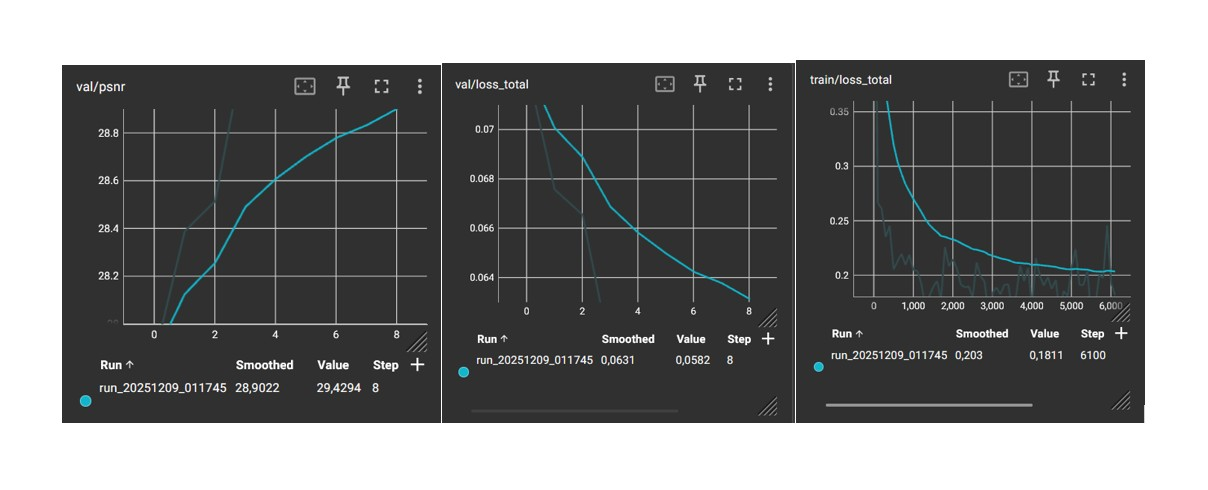

###Analiza wyników

Wykres **val/psnr** ukazuje rosnącą wartość PSNR na zbiorze walidacyjnym. Jest to metryka odwrotna do loss — im wyższy PSNR, tym lepsza jakość generowanej klatki. Stały wzrost wartościświadczy o systematycznym polepszeniu jakości interpolacji. Brak spadków sugeruje stabilne uczenie i poprawne dostrajanie parametrów modelu.

Wykres **val/loss_total** pokazuje spadek błędu na zbiorze walidacyjnym w kolejnych epokach. Krzywa jest gładka i opadająca, co oznacza, że model poprawia swoje działanie również na danych, których nie widział podczas treningu. Brak gwałtownych wzrostów wskazuje, że nie występują symptomy overfittingu — model nie „uczy się na pamięć” danych treningowych, lecz generalizuje swoje działanie.


Wykres **train/loss_total** pokazuje wyraźny, systematyczny spadek wartości loss w miarę postępu treningu. Początkowo strata jest wysoka, jednak szybko maleje i stabilizuje się, co świadczy o tym, że model poprawnie uczy się odwzorowywać zależności występujące w danych. Zauważalne lokalne fluktuacje są typowe dla treningu z wykorzystaniem batchy i nie wskazują na problemy z optymalizacją. Ogólny trend spadkowy potwierdza prawidłowy przebieg procesu uczenia.






##Przykłady interpolacji

Poniżej znajdują się trzy obrazy pokazujące wyniki interpolacji. Zalecamy obejrzenie plików .png dostępnych w plikach naszego repozytorium, w notatniku jakość i kolory mogą być przekłamane.

Na każdym z nich znajdują się dwie klatki sąsiednie (frame 6 i frame 8), klatka ground truth (frame 7) i klatka interpolowana przez model LIFT. Poniżej znajduje się także **error map** (mapa błedu), która przedstawia różnice pomiędzy klatką interpolowaną a ground truth. Obszary zaznaczone jaśniejszymi kolorami wskazują miejsca, w których model popełnia większy błąd rekonstrukcji, natomiast ciemne obszary oznaczają poprawne odwzorowanie struktury i ruchu. Mapa została dodatkowo wzmocniona (x5), aby lepiej uwidocznić lokalne odchylenia, które w oryginalnej skali mogłyby pozostawać niewidoczne. Na dole pokazana jest rubryka z wyliczonymi wartościami metryk, dla danych przykładów.


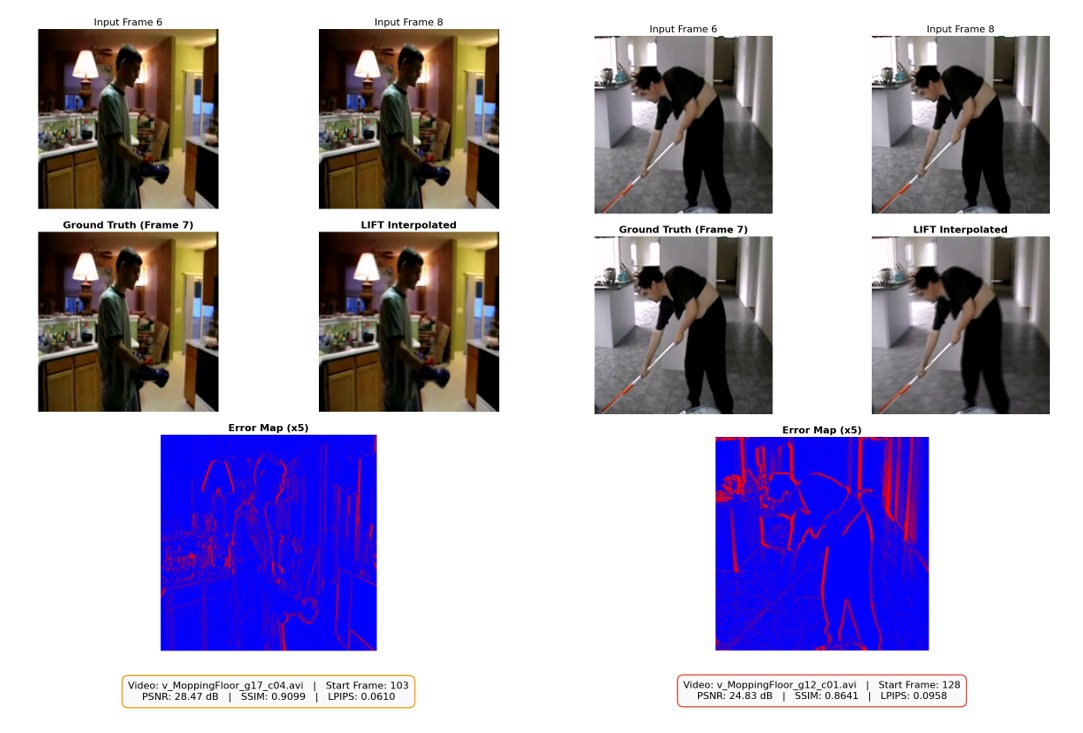

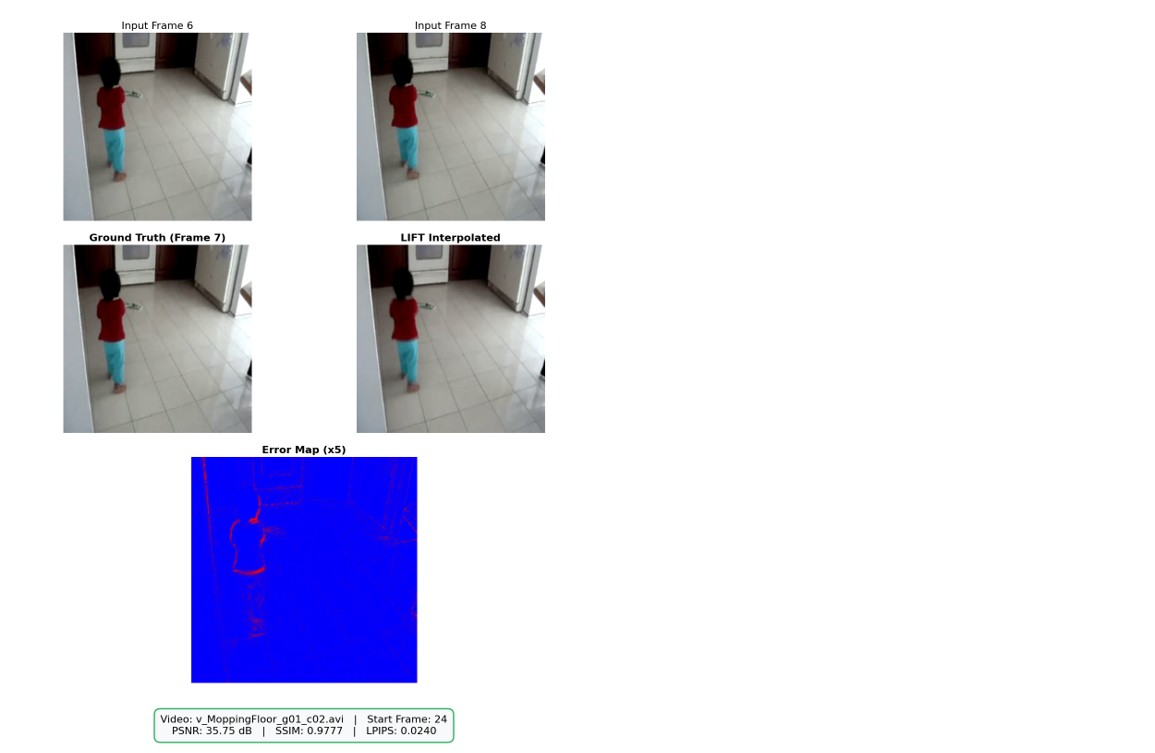

###Analiza wyników

W zaprezentowanych przykładach interpolacji widać, że model LIFT skutecznie odtwarza ogólną strukturę sceny oraz położenie obiektów, a generowane klatki są wizualnie zbliżone do ground truth. W obszarach statycznych lub o niewielkiej dynamice ruchu błędy rekonstrukcji są minimalne, co potwierdzają ciemne regiony na mapach błędu. Zauważalne odchylenia pojawiają się głównie na krawędziach ruchomych obiektów - szczególnie tam, gdzie między klatkami wejściowymi zachodzą szybkie zmiany położenia.

Wyższe wartości błędu w tych regionach wskazują, że największą trudność dla modelu stanowią precyzyjne oszacowanie ruchu i przewidywanie deformacji obiektu w scenach wysokiej dynamiki. Mimo to interpolacje pozostają spójne wizualnie, a różnice percepcyjne są relatywnie niewielkie, co potwierdzają niskie wartości LPIPS. Warto także zauważyć, że nawet w trudniejszych przykładach struktura sylwetki i główne detale są zachowane, co świadczy o efektywnym wykorzystaniu szerokiego kontekstu temporalnego przez model LIFT.